In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from numpy import random

from plotnine import *
%matplotlib inline

# Causal Inference


## Correlation does not imply causation


![Correlation vs Causation](Corcaus.png)

So far, we have been using data to do exploration and make predictions. This is a task that involves understanding correlation. If I observe event A happen every time B happens, then we know that when A happens, we can usually expect B.

However, while correlation can help us predict events, A can't really necessary point us to the reason why B happens.

For example, we know that a rooster singing early in the morning means the sun is about to come up. However, the rooster has no power over the rotation of Earth to cause the event. 

But how do we determine the causes with data?




## The fundamental problem of causal inference

![Fork](https://images.pond5.com/fork-road-empty-arrow-sign-illustration-082185329_iconl_nowm.jpeg)

How do we determine cause? 


We first define a measure of something that must be indicative of change if and only if changes in the presence of an event but would not do so otherwise. Then we say that the event caused the change. 

But can we ever really do this? We can only ever see one state of reality:

1 One in which we have our object of interest experience the event

2 One in which our object of interest does not experience the event


We never observe both things simultaneously. Thus, it is hard for us to figure out if we found cause or simply correlation from observational data. Think about the rooster and the sun once more. This problem is called the 'fundamental problem of causal inference.'

So what can we do?

The answer is interesting as it relies on imagining that we can replicate individuals in a parallel universe. While this is not necessarily reasonable on an individual basis, perhaps it is very feasible in terms of groups.


We can in the end think that we can select groups of individuals whose characteristics are very similar *in distribution*


## Potential outcomes 

Consider an outcome variable (the one that we use to determine if a change has happened) to be a continuous variable that we call $Y$. In the potential outcomes setting, we can use the following notation to denote an individual $i$ being exposed to an event as $Y_i^1$, and one individual $j$ who has not as $Y_j^0$.

Furthermore we will call all individuals in $Y^1$ the 'treatment' group, and all the individuals in $Y^0$ the control group. 

We can express a treated individual $i$ as:


$$Y_i^1=Y_i^0+\delta$$


$\delta$ is called the 'treatment effect.' If we believe that our treatment had no effect (ergo does not cause change) we have that $\delta=0$ and that our treatment and control individuals have the same value! If it has any other value, then we know that our treatment and control measurements are different and that we have a causal effect. In general we will be interested in measuring $\delta$ directly:

$$\delta=Y_i^1-Y_i^0$$


But wait! Remember that we never observe $Y$ for individual $i$ for both treatment and control. So how do we get to measure this treatment effect?


Let's think about how experiments work in hard science:


* We establish a controlled environment in which we are able to manipulate all possible variables


* We take a unit of whatever object we want to subject to an event, and one unit that is not submitted to it

* We make sure that both objects are as close to identical as possible and take measurements of one being subjected to the event and of the one not subjected to it

* We repeat the measurements with new units serveral times to see if we can replicate the experiment

* Since the conditions are identical, and we have made several measurements to control for the little differences among objects if there is any difference between those objects that were subjected to the event than those who were not we know that it comes from the event itself





## Randomized Control Trials (RCTs): Difference in means

As above, what we need to do is find comparable units in similar circumstances and take several measures to identify the differences. To do this in reality we select individuals at random and also assign them to a treatment or control group at random. Since we are trying to measure the treatment effect under repeated measures and finding something that will give us an idea of the difference among distributions, we pick the mean. Ergo, we calculate:

$$\hat{\delta}=mean(Y^1)-mean(Y^0)$$


We would like to see how this looks in practice. However, data for experiments that is open is difficult to access, so we will simulate our own for this exercise. We will generate two groups by using the *normal distribution* (bell curve). We will create the treatment group to have a mean of 1.5 and a standard deviation of 1 and the control group with a mean of zero (default) and a standard deviation of 1. 

In [13]:
Treatment=random.normal(loc=1.5, scale=1, size=10000)

Control=random.normal(loc=0, scale=1, size=10000)

Let's put it in a dataframe

In [14]:
#For treatment

T_df=pd.DataFrame()
T_df['outcome']=Treatment
T_df['treated']=1

#For control

C_df=pd.DataFrame()
C_df['outcome']=Control
C_df['treated']=0

#Concatenate

exp_df=pd.concat([T_df, C_df])


In [16]:
exp_df.head()

,outcome,treated
0,0.130701,1
1,0.898175,1
2,1.859388,1
3,1.589860,1
4,0.031056,1


Let's plot

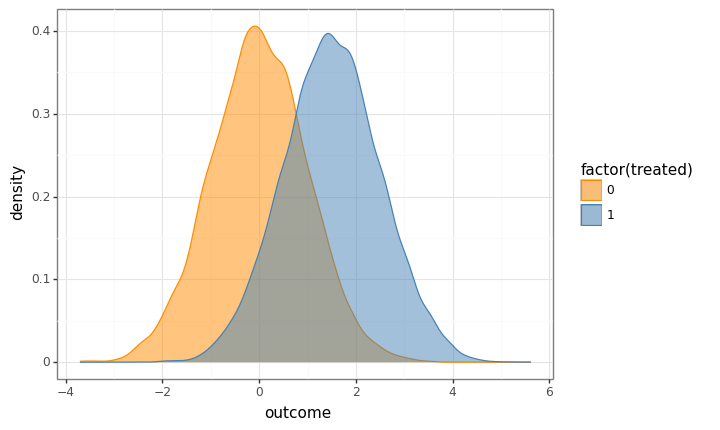

<ggplot: (8767807434665)>

In [17]:
(ggplot(data=exp_df,mapping=aes(x='outcome', color='factor(treated)',
                               fill='factor(treated)'))+
geom_density(alpha=0.5)+
scale_color_manual(values=['darkorange','steelblue'])+ 
 scale_fill_manual(values=['darkorange','steelblue'])+ 
theme_bw())

In this case as we imagined, we have that the distributions seem very similar but the one that has the treatment is shifted to the right. This seems to point out that indeed we have some causal effect. Let's see how large it is by looking at the means. It should let us have a sense of the ATE



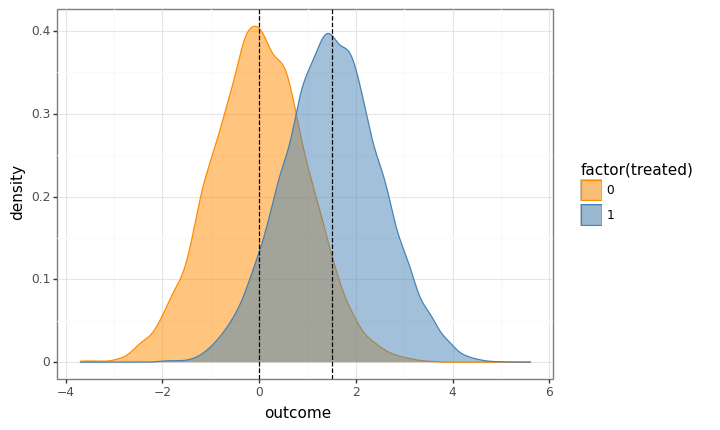

<ggplot: (8767826082687)>

In [18]:
(ggplot(data=exp_df,mapping=aes(x='outcome', color='factor(treated)',
                               fill='factor(treated)'))+
geom_density(alpha=0.5)+
scale_color_manual(values=['darkorange','steelblue'])+ 
 scale_fill_manual(values=['darkorange','steelblue'])+ 
 geom_vline(xintercept=np.mean(Treatment), linetype='dashed')+
  geom_vline(xintercept=np.mean(Control), linetype='dashed')+

theme_bw())

Let's now measure the ATE:

In [19]:
np.mean(Treatment)-np.mean(Control)

1.5030666713177996

Great! It matches what we had thought. However, how do we know if this is significant? There are a few ways in which we can check this. But I also want to take this opportunity to show the equivalence of getting the ATE by simply taking the difference of means to desgining a specific regression for it!

## Regression and RCTs

Let's define a variable $T$ which takes the following values:


$$T=\begin{cases}
        1, \mbox{if Treated}\\ 
        0, \mbox{Otherwise} \\
        \end{cases}$$
        
Now, let's think about our potential outcomes again. We know that for any outcome $Y$, we have that:

$$Y=\begin{cases}
        Y^1, \mbox{if Treated}\\ 
        Y^0, \mbox{Otherwise} \\
        \end{cases}$$
        
        
Which we can summarize like this:


$$Y=Y^0+(Y^1-Y^0)T$$

This is called the switching equation. Note that if $T$ is 1 we get $Y^1$ and if $T$ is zero we do get $Y^0$.

Let's look at the term $Y^1-Y^0$ and let's remember the definition of $\delta$. Recalling that parameters in regression go back to the mean, we can think of this like:


$$mean(Y)=mean(Y^0)+mean(Y^1-Y^0)T$$

So we could define a regression:

$$Y=\beta_0+\delta T+\varepsilon$$

where

$$\beta_0=Y^0$$
$$\delta=Y^1-Y^0$$

If we run the regression the estimate of $\hat{\delta}$ will be our ATE and the result of the t-tests will allow us to know if the effect is significantly different from zero.

Let's actually run the regression




In [20]:
# y is outcome, X is treated on our exp_df dataframe

reg1 = smf.ols('outcome ~ treated',exp_df).fit()

In [21]:
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 1.134e+04
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:10:49   Log-Likelihood:                -28339.
No. Observations:               20000   AIC:                         5.668e+04
Df Residuals:                   19998   BIC:                         5.670e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.010     -0.087      0.931      -0.020       0.019
treated        1.5031      0.014    106.488      0.000       1.475       1.531
==============================================================================
Omnibus:                        0.701   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.725
Skew:                           0.009   Prob(JB):                        0.696
Kurtosis:                       2.976   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's look at the parameters again:

In [22]:
reg1.params

Intercept   -0.000865
treated      1.503067
dtype: float64

The treated parameter is our $\hat{\delta}$ and it matches what we expect! Let's look at the significance next

In [23]:
reg1.conf_int()

,0,1
Intercept,-0.020428,0.018698
treated,1.475400,1.530733


We see that the 95% confidence intervals for treated have a lower bound of 1.48 and an upper bound of 1.53. We know that this treatment effect is significantly different from zero because the interval does not enclose zero! For now, we are happy with these results. We will start exploring what happens when we cannot do experiments later on 

Some datasets for your project:

https://www.kdnuggets.com/datasets/index.html